# Preamble

In [1]:
%matplotlib widget

import os, glob, pathlib
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

from loky import get_reusable_executor
import dill as pickle

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

def fs1(alpha):
    """
    fs,1 in MD table 8.4 p. 331
    (1/8)*(2*α*D+α**2*D^2)*b^(0)_(1/2)(α)
    """
    return 0.125 * (2*alpha*Db(0.5,0,alpha) + alpha**2*D2b(0.5,0,alpha))

def fs2(alpha):
    """ 
    fs,2 in MD table 8.4 p. 331
    (1/4)*(2-2*α*D-α**2*D^2)*b^(1)_(1/2)(α)
    """
    return 0.25*(2*b(0.5,1,alpha)-2*alpha*Db(0.5,1,alpha)-alpha**2*D2b(0.5,1,alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val = f27lc(alpha0, 2)
f2val = f31lc(alpha0, 2)
f3val = fs1(alpha0)
f4val = fs2(alpha0)

IPython console for SymPy 1.11.1 (Python 3.11.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



In [2]:
f1val, f2val, f3val, f4val

# Poisson Bracket

In [3]:
class PoissonBracket:
    def __init__(self, q, p):
        """
        q : list of canonical coordinates
        p : list of canonical momenta
        """
        self.dim = len(q)
        if len(p) != self.dim:
            raise Warning("Mismatch in canonical conjugate pair dimensions.")
        self.q = q
        self.p = p
    def __call__(self, f, g):
        """
        f, g : Functions of canonical conjugate pairs p, q
        """
        bracket = 0
        for i in range(self.dim):
            bracket += f.diff(self.p[i])*g.diff(self.q[i]) - g.diff(self.p[i])*f.diff(self.q[i])
        return(bracket)

# Hamiltonian and Canonical Variables

In [4]:
a1, a2, e1, e2, mu2, l1, l2, pom1, pom2, f1, f2, f3, f4, j, om1, om2 = symbols(
    r"a_1 a_2 e_1 e_2 mu_2 lambda_1 lambda_2 varpi_1 varpi_2 f_1 f_2 f_3 f_4 j \omega_{1\rm{e}} \omega_{2\rm{e}}"
)
q = symbols(r"q", positive=True)
calH = (
    -q / (2 * a1)
    - 1 / (2 * a2)
    - q* mu2/ a2
    * f1 * e1 * cos((j + 1) * l2 - j * l1 - pom1)
    - q* mu2/ a2* f2 * e2 * cos((j + 1) * l2 - j * l1 - pom2)
    -om1*Rational(1,2)*q*sqrt(a1)*e1**2
    -om2*Rational(1,2)*sqrt(a2)*e2**2
    -q*mu2/a2*f3*(e1**2+e2**2) -q*mu2/a2*f4*e1*e2*cos(pom1-pom2)
)
calH

In [5]:
#a1, a2, e1, e2, mu2, l1, l2, pom1, pom2, f1, f2, f3, f4, j, e3, a3, mu3, f5, f6, f7, f8 = symbols(
#    r"a_1 a_2 e_1 e_2 mu_2 lambda_1 lambda_2 varpi_1 varpi_2 f_1 f_2 f_3 f_4 j e_3 a_3 mu_3 f_5 f_6 f_7 f_8"
#)
#q = symbols(r"q", positive=True)
#calH = (
#    -q / (2 * a1)
#    - 1 / (2 * a2)
#    - q* mu2/ a2
#    * f1 * e1 * cos((j + 1) * l2 - j * l1 - pom1)
#    - q* mu2/ a2* f2 * e2 * cos((j + 1) * l2 - j * l1 - pom2)
#    -q*mu2/a2*f3*(e1**2+e2**2) -q*mu2/a2*f4*e1*e2*cos(pom1-pom2)
#    -q*mu3/a3*f5*(e1**2)-q*mu3/a3*f6*(e1*e3)*cos(pom1)
#    -mu3/a3*f7*(e2**2)-q*mu3/a3*f8*(e2*e3)*cos(pom2)
#)
## assume pomega_3 = 0
#calH

In [6]:
L1, L2, G1, G2 = symbols("Lambda_1 Lambda_2 Gamma_1 Gamma_2", positive=True)
g1, g2 = symbols("gamma_1 gamma_2")

In [7]:
def orbelts_to_delaunay(expr):
    return expr.subs(
        {
            e1: sqrt(2 * G1 / L1),
            e2: sqrt(2 * G2 / L2),
            a1: L1**2/q**2,
            a2: L2**2,
            pom1: -g1,
            pom2: -g2,
        }
    )


def delaunay_to_orbelts(expr):
    return expr.subs(
        {
            g1: -pom1,
            g2: -pom2,
            G1: Rational(1, 2) * L1 * e1**2,
            G2: Rational(1, 2) * L2 * e2**2,
            L1: q*sqrt(a1),
            L2: sqrt(a2),
        }
    )

# Canonical transformations for numerical experiments

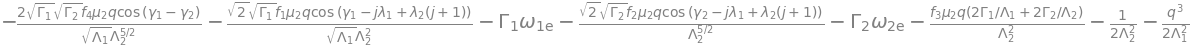

In [8]:
H1 = orbelts_to_delaunay(calH).subs({sqrt(L1**2):L1,sqrt(L2**2):L2})
H1

In [9]:
Th0, th0, K0, k0 = symbols("Theta_0 theta_0 K_0 k_0")

In [10]:
genF1 = {}
genF1["func"] = -Th0*((j+1)*l2 - j*l1) + K0*l2
genF1["L1"] = genF1["func"].diff(l1)
genF1["L2"] = genF1["func"].diff(l2)
genF1["th0"] = genF1["func"].diff(Th0)
genF1["k0"] = genF1["func"].diff(K0)


genF1["l2"] = solve(k0-genF1["k0"],l2)[0]
genF1["l1"] = solve(th0-genF1["th0"],l1)[0].subs(l2,genF1["l2"])
genF1["Th0"] = solve(L1-genF1["L1"],Th0)[0]
genF1["K0"] = solve(L2-genF1["L2"],K0)[0].subs(Th0,genF1["Th0"])

for key in genF1.keys():
    display(key,genF1[key])

'func'

'L1'

'L2'

'th0'

'k0'

'l2'

'l1'

'Th0'

'K0'

In [11]:
PB = PoissonBracket([l1,l2],[L1,L2])
PB(genF1["K0"],genF1["k0"]),PB(genF1["Th0"],genF1["th0"])

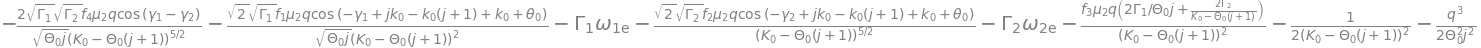

In [12]:
H1.subs({
    l1:genF1["l1"],
    l2:genF1["l2"],
    L1:genF1["L1"],
    L2:genF1["L2"],
})

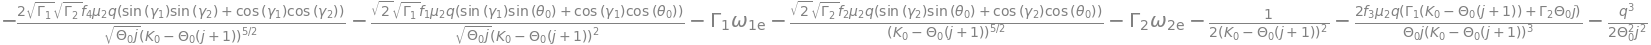

In [13]:
H2 = expand_trig(H1.subs({
    l1:genF1["l1"],
    l2:genF1["l2"],
    L1:genF1["L1"],
    L2:genF1["L2"],
}).trigsimp())
H2p = 0
for term in H2.args:
    H2p += expand_trig(term.simplify())
H2p
H2 = H2p
H2

In [14]:
X1, X2, Y1, Y2 = symbols("X_1 X_2 Y_1 Y_2")
PBgG = PoissonBracket([g1, g2], [G1, G2])
X1_expr, Y1_expr = sqrt(2*G1) * sin(g1), sqrt(2*G1) * cos(g1)
X2_expr, Y2_expr = sqrt(2*G2) * sin(g2), sqrt(2*G2) * cos(g2)
display(PBgG(Y1_expr,X1_expr).simplify())
display(PBgG(Y2_expr,X2_expr).simplify())

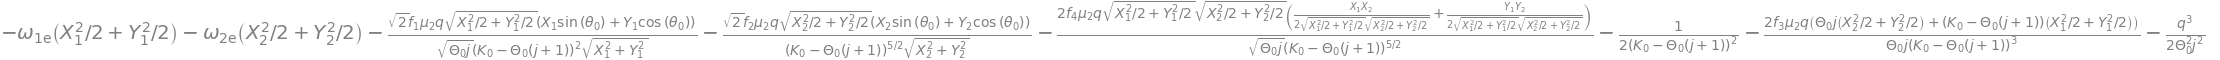

In [15]:
H3 = H2.subs(
    {
        sin(g1): X1 / sqrt(2 * G1),
        cos(g1): Y1 / sqrt(2 * G1),
        sin(g2): X2 / sqrt(2 * G2),
        cos(g2): Y2 / sqrt(2 * G2),
        G1:Rational(1,2)*(X1**2+Y1**2),
        G2:Rational(1,2)*(X2**2+Y2**2),
    }
).trigsimp()#.simplify(deep=True).expand()
H3

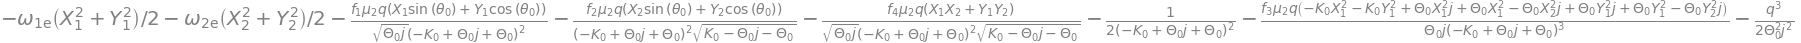

In [16]:
H4 = 0
for term in H3.args:
    H4 += term.cancel().simplify(deep=True).factor()
H4

# Dissipation

In [17]:
Te1, Te2, Tm1, Tm2 = symbols(r"T_{\rm{e}1} T_{\rm{e}2} T_{\rm{m}1} T_{\rm{m}2}")

In [18]:
a1dot_dis = -a1/Tm1 - 2*e1**2*a1/Te1
a2dot_dis = -a2/Tm2 - 2*e2**2*a2/Te2

e1dot_dis = -e1/Te1
e2dot_dis = -e2/Te2

a1dot_dis,e1dot_dis,a2dot_dis,e2dot_dis

In [19]:
genF1["Th0"]

In [20]:
Th0dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(genF1["Th0"]).diff(a1) * a1dot_dis
        + delaunay_to_orbelts(genF1["Th0"]).diff(a2) * a2dot_dis
    )
    .subs({G1: Rational(1, 2) * (X1**2 + Y1**2), L1: genF1["L1"]})
    .subs({G2: Rational(1, 2) * (X2**2 + Y2**2), L2: genF1["L2"]})
).expand()
Th0dot_dis

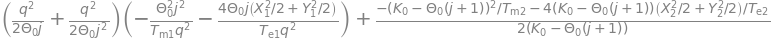

In [21]:
K0dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(genF1["K0"]).diff(a1) * a1dot_dis
        + delaunay_to_orbelts(genF1["K0"]).diff(a2) * a2dot_dis
    )
    .subs({G1: Rational(1, 2) * (X1**2 + Y1**2), L1: genF1["L1"]})
    .subs({G2: Rational(1, 2) * (X2**2 + Y2**2), L2: genF1["L2"]})
)

K0dot_dis

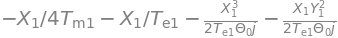

In [22]:
X1dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(X1_expr).diff(a1) * a1dot_dis
        + delaunay_to_orbelts(X1_expr).diff(e1) * e1dot_dis
    )
    .subs(L1, genF1["L1"])
    .subs({
        sin(g1): X1 / sqrt(2 * G1),
        G1: Rational(1,2)*(X1**2+Y1**2)
        })
).expand()
X1dot_dis

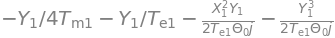

In [23]:
Y1dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(Y1_expr).diff(a1) * a1dot_dis
        + delaunay_to_orbelts(Y1_expr).diff(e1) * e1dot_dis
    )
    .subs(L1, genF1["L1"])
    .subs({
        cos(g1): Y1 / sqrt(2 * G1),
        G1: Rational(1,2)*(X1**2+Y1**2)
        })
).expand()
Y1dot_dis

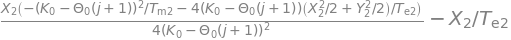

In [24]:
X2dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(X2_expr).diff(a2) * a2dot_dis
        + delaunay_to_orbelts(X2_expr).diff(e2) * e2dot_dis
    )
    .subs(L2, genF1["L2"])
    .subs({
        sin(g2): X2 / sqrt(2 * G2),
        G2: Rational(1,2)*(X2**2+Y2**2)
        })
)
X2dot_dis

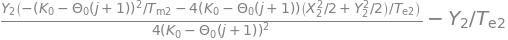

In [25]:
Y2dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(Y2_expr).diff(a2) * a2dot_dis
        + delaunay_to_orbelts(Y2_expr).diff(e2) * e2dot_dis
    )
    .subs(L2, genF1["L2"])
    .subs({
        cos(g2): Y2 / sqrt(2 * G2),
        G2: Rational(1,2)*(X2**2+Y2**2)
        })
)
Y2dot_dis

# Class 

In [26]:
class RHS:
    def __init__(self, qval, mu2val, Te1val, Te2val, Tm1val, Tm2val, mu3val, a3val, e3val, showeqns=False):
        self.qval = qval
        self.mu2val = mu2val
        self.Te1val = Te1val
        self.Te2val = Te2val
        self.Tm1val = Tm1val
        self.Tm2val = Tm2val
        self.mu3val  = mu3val 
        self.a3val   = a3val  
        self.e3val   = e3val  

        self.f5val = fs1(alpha0/self.a3val)
        self.f6val = fs2(alpha0/self.a3val)
        self.f7val = fs1(1/self.a3val)
        self.f8val = fs2(1/self.a3val)

        H_eom = H4

        X1dot = self.plugin(H_eom.diff(Y1) + X1dot_dis)
        Y1dot = self.plugin(-H_eom.diff(X1) + Y1dot_dis)
        X2dot = self.plugin(H_eom.diff(Y2) + X2dot_dis)
        Y2dot = self.plugin(-H_eom.diff(X2) + Y2dot_dis)
        Th0dot = self.plugin(-H_eom.diff(th0) + Th0dot_dis)
        th0dot = self.plugin(H_eom.diff(Th0))
        K0dot = self.plugin(K0dot_dis)

        self.X1dot_func = lambdify([X1, Y1, X2, Y2, Th0, th0, K0], X1dot)
        self.Y1dot_func = lambdify([X1, Y1, X2, Y2, Th0, th0, K0], Y1dot)
        self.X2dot_func = lambdify([X1, Y1, X2, Y2, Th0, th0, K0], X2dot)
        self.Y2dot_func = lambdify([X1, Y1, X2, Y2, Th0, th0, K0], Y2dot)
        self.Th0dot_func = lambdify([X1, Y1, X2, Y2, Th0, th0, K0], Th0dot)
        self.th0dot_func = lambdify([X1, Y1, X2, Y2, Th0, th0, K0], th0dot)
        self.K0dot_func = lambdify([X1, Y1, X2, Y2, Th0, th0, K0], K0dot)

        a1_func = solve(
            [
                delaunay_to_orbelts(genF1["Th0"] - Th0),
                delaunay_to_orbelts(genF1["K0"] - K0),
            ],
            a1,
        )[0][0]
        a2_func = solve(
            [
                delaunay_to_orbelts(genF1["Th0"] - Th0),
                delaunay_to_orbelts(genF1["K0"] - K0),
            ],
            a2,
        )[0][0]

        self.a1_func = lambdify([Th0, j, q], a1_func)
        self.a2_func = lambdify([K0, j, q, a1], a2_func)
        self.e1_func = lambdify(
            [G1, a1, q], abs(solve(delaunay_to_orbelts(G1) - G1, e1)[0])
        )
        self.e2_func = lambdify(
            [G2, a2, q], abs(solve(delaunay_to_orbelts(G2) - G2, e2)[0])
        )


        if showeqns:
            display(
                X1dot,
                Y1dot,
                X2dot,
                Y2dot,
                Th0dot,
                th0dot,
                K0dot,
            )

    def plugin(self, expr):
        return expr.subs(
            {
                q: self.qval,
                mu2: self.mu2val,
                f1: f1val,
                f2: f2val,
                f3: f3val,
                f4: f4val,
                #f5: self.f5val,
                #f6: self.f6val,
                #f7: self.f7val,
                #f8: self.f8val,
                j: 2,
                Te1: self.Te1val,
                Te2: self.Te2val,
                Tm1: self.Tm1val,
                Tm2: self.Tm2val,
                #mu3: self.mu3val,
                #a3:  self.a3val,
                #e3:  self.e3val,
                om1: 0,
                om2: 0,
            }
        ).evalf()

    def orb_elts_from_integration(self, integration):
        y = integration.y
        X1_vals = y[0, :].astype(float)
        Y1_vals = y[1, :].astype(float)
        X2_vals = y[2, :].astype(float)
        Y2_vals = y[3, :].astype(float)
        Th0_vals = y[4, :].astype(float)
        th0_vals = y[5, :].astype(float)
        K0_vals = y[6, :].astype(float)

        G1_vals = 0.5 * (X1_vals**2 + Y1_vals**2)
        G2_vals = 0.5 * (X2_vals**2 + Y2_vals**2)

        a1_vals = self.a1_func(Th0_vals, 2, self.qval)
        a1_vals = np.float64(a1_vals)
        a2_vals = self.a2_func(K0_vals, 2, self.qval, a1_vals)
        a2_vals = np.float64(a2_vals)

        e1_vals = self.e1_func(G1_vals, a1_vals, self.qval)
        e2_vals = self.e2_func(G2_vals, a2_vals, self.qval)
        e1_vals = np.float64(e1_vals)
        e2_vals = np.float64(e2_vals)

        pom1_vals = -np.arctan2(X1_vals, Y1_vals)
        pom2_vals = -np.arctan2(X2_vals, Y2_vals)

        return (
            integration.t,
            e1_vals,
            pom1_vals,
            e2_vals,
            pom2_vals,
            a1_vals,
            th0_vals,
            a2_vals,
        )

    def __call__(self, t, Y):
        return np.array(
            [
                self.X1dot_func(*Y),
                self.Y1dot_func(*Y),
                self.X2dot_func(*Y),
                self.Y2dot_func(*Y),
                self.Th0dot_func(*Y),
                self.th0dot_func(*Y),
                self.K0dot_func(*Y),
            ]
        )

    def init(self, e1val, pom1val, e2val, pom2val, a1val, th0val, a2val):
        return [
            (
                delaunay_to_orbelts(sqrt(2 * G1))
                .subs({e1: e1val, a1: a1val, q: self.qval})
                .evalf()
            )
            * np.sin(-pom1val),
            (
                delaunay_to_orbelts(sqrt(2 * G1))
                .subs({e1: e1val, a1: a1val, q: self.qval})
                .evalf()
            )
            * np.cos(-pom1val),
            (
                delaunay_to_orbelts(sqrt(2 * G2))
                .subs({e2: e2val, a2: a2val, q: self.qval})
                .evalf()
            )
            * np.sin(-pom2val),
            (
                delaunay_to_orbelts(sqrt(2 * G2))
                .subs({e2: e2val, a2: a2val, q: self.qval})
                .evalf()
            )
            * np.cos(-pom2val),
            delaunay_to_orbelts(genF1["Th0"])
            .subs({a1: a1val, a2: a2val, j: 2, q: self.qval})
            .evalf(),
            th0val,
            delaunay_to_orbelts(genF1["K0"])
            .subs({a1: a1val, a2: a2val, j: 2, q: self.qval})
            .evalf(),
        ]

In [27]:
def run(qval, mu2val, T, a10val, Te1val, Te2val, Tm1val, Tm2val, mu3val, a3val, e3val):
    qval = np.float64(qval)
    rhs = RHS(qval, mu2val, Te1val, Te2val, Tm1val, Tm2val, mu3val, a3val, e3val, showeqns=False)

    def f(t, Y):
        return rhs(t, Y)

    tspan = (0, T)
    t_eval = np.linspace(tspan[0], tspan[1], 10000)

    ##################
    # SMA boundaries #
    ##################
    def event0(t, Y):
        Th0val = np.float64(Y[4])
        return rhs.a1_func(Th0val, 2, qval) - 2

    def event1(t, Y):
        Th0val = np.float64(Y[4])
        return rhs.a1_func(Th0val, 2, qval) - 0.3

    def event2(t, Y):
        Y = Y.astype(np.float64)
        a1val = rhs.a1_func(Y[4], 2, qval)
        a1val = np.float64(a1val)
        K0val = np.float64(Y[6])
        jval = np.float64(2.0)
        return rhs.a2_func(K0val, jval, qval, a1val) - 2.0

    def event3(t, Y):
        Y = Y.astype(np.float64)
        a1val = rhs.a1_func(Y[4], 2, qval)
        a1val = np.float64(a1val)
        K0val = np.float64(Y[6])
        jval = np.float64(2.0)
        return rhs.a2_func(K0val, jval, qval, a1val) - 0.3

    ##################
    # orbit crossing #
    ##################
    def event4(t, Y):
        G1_val = np.float64(0.5 * (Y[0] ** 2 + Y[1] ** 2))
        G2_val = np.float64(0.5 * (Y[2] ** 2 + Y[3] ** 2))
        Th0val = np.float64(Y[4])
        K0val = np.float64(Y[6])
        a1val = rhs.a1_func(Th0val, 2, qval)
        a1val = np.float64(a1val)
        a2val = rhs.a2_func(K0val, 2, qval, a1val)
        e1val = rhs.e1_func(G1_val, a1val, qval)
        e2val = rhs.e2_func(G2_val, a2val, qval)
        return a1val * (1 + e1val) - a2val * (1 - e2val)

    ##########
    # escape #
    ##########
    def event5(t, Y):
        Th0val = np.float64(Y[4])
        K0val = np.float64(Y[6])
        G1_val = np.float64(0.5 * (Y[0] ** 2 + Y[1] ** 2))
        a1val = rhs.a1_func(Th0val, 2, qval)
        a1val = np.float64(a1val)
        e1val = rhs.e1_func(G1_val, a1val, qval)
        return e1val - 1

    def event6(t, Y):
        Th0val = np.float64(Y[4])
        K0val = np.float64(Y[6])
        G2_val = np.float64(0.5 * (Y[2] ** 2 + Y[3] ** 2))
        a1val = rhs.a1_func(Th0val, 2, qval)
        a1val = np.float64(a1val)
        a2val = rhs.a2_func(K0val, 2, qval, a1val)
        e2val = rhs.e2_func(G2_val, a2val, qval)
        return e2val - 1

    event0.terminal = True
    event1.terminal = True
    event2.terminal = True
    event3.terminal = True
    event4.terminal = True
    event5.terminal = True
    event6.terminal = True

    initorbelts = [
        0.0,  # e1
        0.0,  # pom1
        0.0,  # e2
        np.pi/2,  # pom2
        a10val,  # a1
        -3*np.pi/4,  # th0
        1,  # a2
    ]
    initVals = np.array(rhs.init(*initorbelts))

    integration = sp.integrate.solve_ivp(
        f,
        tspan,
        initVals,
        rtol=1e-12,
        atol=1e-12,
        t_eval=t_eval,
        events=[event0, event1, event2, event3, event4, event5, event6],
        method="DOP853",
    )
    return integration, np.array(rhs.orb_elts_from_integration(integration))

In [28]:
a3val = 4
mu3vals = np.logspace(-4,-1,100)
f5val = fs1(alpha0/a3val)
f6val = fs2(alpha0/a3val)
f7val = fs1(1/a3val)
f8val = fs2(1/a3val)
om1_0 = 2*mu3vals*f5val/a3val/np.sqrt(alpha0)
om2_0 = 2*mu3vals*f7val/a3val
#with mpl.rc_context(analytic):
#    fig, ax = plt.subplots()
#ax.plot(mu3vals,om1_0)
#ax.plot(mu3vals,om2_0)
#ax.plot(mu3vals,om2_0-om1_0)
#ax.set_yscale("log")
#ax.set_xscale("log")
#fig.tight_layout()

In [29]:
def solve_ivp(ps):
    return ps, *run(*ps)

- [0] integration.t,
- [1] e1_vals,
- [2] pom1_vals,
- [3] e2_vals,
- [4] pom2_vals,
- [5] a1_vals,
- [6] th0_vals,
- [7] a2_vals,

# One shot

In [30]:
qval = 0.5
int, y = run(
    qval,
    6e-6,
    5e4 * 2 * np.pi,
    0.7,
    1e3 * 2 * np.pi/ qval,
    1e3 * 2 * np.pi,
    np.inf,
    1e5 * 2 * np.pi,
    0,#1e-3,
    4,
    0.0,
)

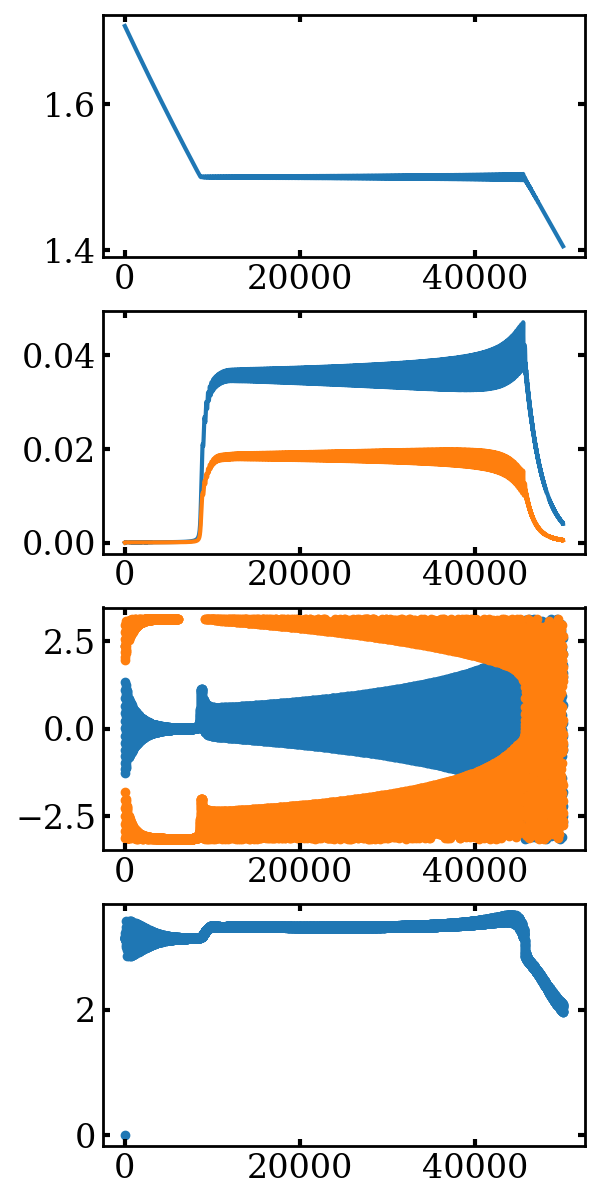

In [31]:
fig, ax = plt.subplots(4, figsize=(6, 12))
t = y[0, :]
a1_vals = y[5, :]
a2_vals = y[7, :]
e1_vals = y[1, :]
e2_vals = y[3, :]
pom1_vals = y[2, :]
pom2_vals = y[4, :]
th0_vals = y[6, :]
pom1_vals = pom1_vals % (2 * np.pi)
pom2_vals = pom2_vals % (2 * np.pi)
pom1_vals = pom1_vals - 2 * np.pi * (pom1_vals > np.pi)
pom2_vals = pom2_vals - 2 * np.pi * (pom2_vals > np.pi)
th1 = (-th0_vals - pom1_vals) % (2 * np.pi)
th2 = (-th0_vals - pom2_vals) % (2 * np.pi)
th1 = th1 - 2 * np.pi * (th1 > np.pi)
th2 = th2 - 2 * np.pi * (th2 > np.pi)
ax[0].plot(t / 2 / np.pi, 1 / (a1_vals / a2_vals) ** (1.5))
ax[1].plot(t / 2 / np.pi, e1_vals)
ax[1].plot(t / 2 / np.pi, e2_vals)
ax[2].scatter(t / 2 / np.pi, th1)
ax[2].scatter(t / 2 / np.pi, th2)
ax[3].scatter(t/2/np.pi,(pom1_vals-pom2_vals)%(2*np.pi))
fig.tight_layout()

# Capture

In [47]:
aratio = (2/3)**(2./3)
aratio

In [48]:
np.logspace(-6,-2,30)

array([1.00000000e-06, 1.37382380e-06, 1.88739182e-06, 2.59294380e-06,
       3.56224789e-06, 4.89390092e-06, 6.72335754e-06, 9.23670857e-06,
       1.26896100e-05, 1.74332882e-05, 2.39502662e-05, 3.29034456e-05,
       4.52035366e-05, 6.21016942e-05, 8.53167852e-05, 1.17210230e-04,
       1.61026203e-04, 2.21221629e-04, 3.03919538e-04, 4.17531894e-04,
       5.73615251e-04, 7.88046282e-04, 1.08263673e-03, 1.48735211e-03,
       2.04335972e-03, 2.80721620e-03, 3.85662042e-03, 5.29831691e-03,
       7.27895384e-03, 1.00000000e-02])

In [32]:
for om2val in [0,*np.logspace(-6,-2,29)]:
    print(om2val*(1-aratio**3),)

0.0
5.555555555555555e-07
7.719419413184106e-07
1.0726098493795832e-06
1.490386552933182e-06
2.0708854001749656e-06
2.8774859329062293e-06
3.998253738895286e-06
5.555555555555557e-06
7.71941941318409e-06
1.0726098493795832e-05
1.490386552933182e-05
2.0708854001749657e-05
2.8774859329062294e-05
3.998253738895286e-05
5.555555555555556e-05
7.719419413184097e-05
0.00010726098493795831
0.00014903865529331803
0.00020708854001749656
0.0002877485932906227
0.0003998253738895286
0.0005555555555555556
0.0007719419413184097
0.0010726098493795831
0.0014903865529331804
0.0020708854001749654
0.0028774859329062266
0.0039982537388952855
0.005555555555555556


In [37]:
params = []
for om2val in [0,*np.logspace(-6,-2,29)]:
    params += [
        (
            om2val*(aratio**3),
            om2val,
            qval,
            1.2e-5,
            3e5 * 2 * np.pi,
            5e2 * 2 * np.pi / qval,
            5e2 * 2 * np.pi,
            np.inf,
            1e6 * 2 * np.pi,
        )
    ]

In [38]:
executors_solve_ivp = get_reusable_executor(max_workers=30)
results = list(executors_solve_ivp.map(solve_ivp, params))

In [ ]:
fig, ax = plt.subplots(2)
for result in results:
    t = result[2][0,:]
    a1_vals = result[2][5,:]
    a2_vals = result[2][7,:]
    e1_vals = result[2][1,:]
    ax[1].plot(t/2/np.pi, (a1_vals/a2_vals)**(1.5))
    ax[0].plot(t/2/np.pi, e1_vals)

In [ ]:
fig, ax = plt.subplots(2)
for result in results:
    t = result[2][0, :]
    a1_vals = result[2][5, :]
    a2_vals = result[2][7, :]
    e1_vals = result[2][1, :]
    e2_vals = result[2][3, :]
    ps = result[0]
    om2val = ps[1]
    itavg = np.where(t > 2e5 * 2 * np.pi)[0][0]
    ax[0].scatter(om2val, np.average(e1_vals[itavg:]))
    ax[0].scatter(om2val, np.average(e2_vals[itavg:]))
    ax[1].scatter(om2val, np.average((a1_vals[itavg:] / a2_vals[itavg:])))
fig.tight_layout()

In [278]:
5e-4*(aratio**3-1)

In [275]:
1.2e-5**(2./3)

In [ ]:
qval = 0.5
omval = 5e-4
int, y = run(
    omval*aratio**3,
    omval,
    qval,
    1.2e-5,
    1e6 * 2 * np.pi,
    1e4 * 2 * np.pi / qval,
    1e4 * 2 * np.pi,
    np.inf,
    1e7 * 2 * np.pi,
)

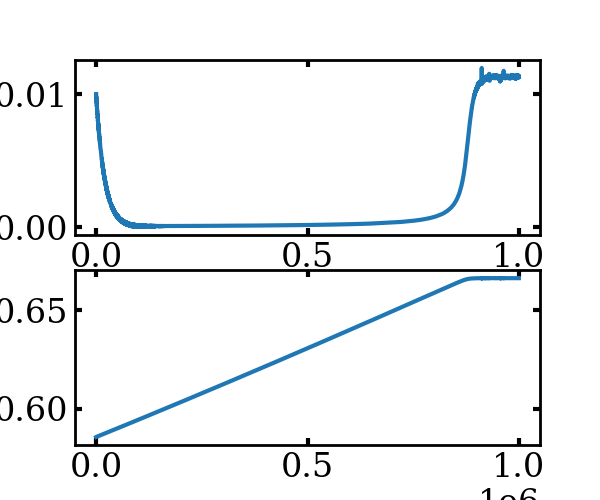

In [36]:
fig, ax = plt.subplots(2)
t = y[0,:]
a1_vals = y[5,:]
a2_vals = y[7,:]
e1_vals = y[1,:]
ax[1].plot(t/2/np.pi, (a1_vals/a2_vals)**(1.5))
ax[0].plot(t/2/np.pi, e1_vals)

# $e_1$ and $e_2$ and $a_1/a_2$ values as function of $T_e/T_m$

In [236]:
params = []
for Tratio in np.arange(3, 26) * 10 * 0.00001:
    Tmval = 1e6 * 2 * np.pi
    params += [
        (
            0,
            0,
            qval,
            1.2e-5,
            3e5 * 2 * np.pi,
            Tmval * Tratio / qval,
            Tmval * Tratio,
            np.inf,
            Tmval,
        )
    ]

In [237]:
executors_solve_ivp = get_reusable_executor(max_workers=17)
results = list(executors_solve_ivp.map(solve_ivp, params))

<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in scalar power
  return -Dummy_87*Y_2 - 7.95774715459477e-5*X_2 + 0.0277777777777778*X_2*(-1.43239448782706e-6*(0.333333333333333*K_0 - Theta_0)**2 - 0.000318309886183791*(K_0 - 3.0*Theta_0)*(0.5*X_2**2 + 0.5*Y_2**2))/(0.333333333333333*K_0 - Theta_0)**2 - 9.56094040832637e-7*(0.333333333333333*K_0 - Theta_0)**(-0.5)*cos(theta_0)/(-0.333333333333333*K_0 + Theta_0)**2
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in scalar power
  return Dummy_89*X_2 - 7.95774715459477e-5*Y_2 + 0.0277777777777778*Y_2*(-1.43239448782706e-6*(0.333333333333333*K_0 - Theta_0)**2 - 0.000318309886183791*(K_0 - 3.0*Theta_0)*(0.5*X_2**2 + 0.5*Y_2**2))/(0.333333333333333*K_0 - Theta_0)**2 + 9.56094040832637e-7*(0.333333333333333*K_0 - Theta_0)**(-0.5)*sin(theta_0)/(-0.333333333333333*K_0 + Theta_0)**2
<lambdifygenerated-16>:2: RuntimeWarning: invalid value encountered in scalar power
  return -9.54699131645628e-7*Theta_0**

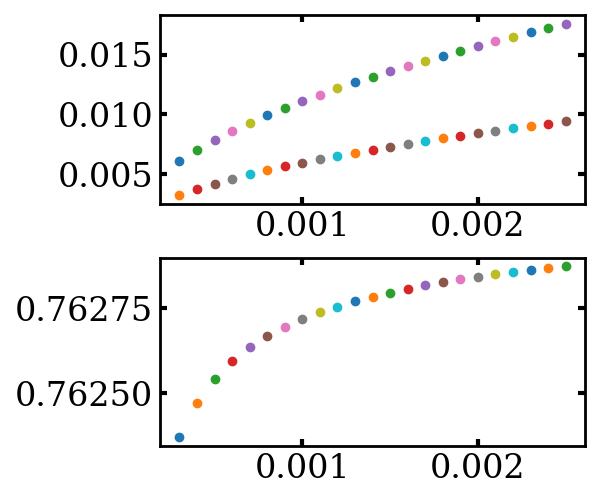

In [252]:
fig, ax = plt.subplots(2)
for result in results:
    t = result[2][0,:]
    a1_vals = result[2][5,:]
    a2_vals = result[2][7,:]
    e1_vals = result[2][1,:]
    e2_vals = result[2][3,:]
    ps = result[0]
    Tratio = ps[6]/ps[8]
    itavg = np.where(t>2e5*2*np.pi)[0][0]
    ax[0].scatter(Tratio, np.average(e1_vals[itavg:]))
    ax[0].scatter(Tratio, np.average(e2_vals[itavg:]))
    ax[1].scatter(Tratio, np.average((a1_vals[itavg:]/a2_vals[itavg:])))
fig.tight_layout()

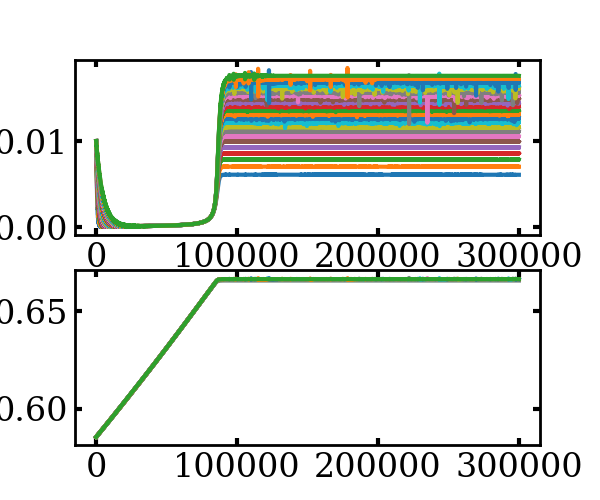

In [240]:
fig, ax = plt.subplots(2)
for result in results:
    t = result[2][0,:]
    a1_vals = result[2][5,:]
    a2_vals = result[2][7,:]
    e1_vals = result[2][1,:]
    ax[1].plot(t/2/np.pi, (a1_vals/a2_vals)**(1.5))
    ax[0].plot(t/2/np.pi, e1_vals)

/tmp/ipykernel_3297304/3215124186.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3, figsize=(5, 9))


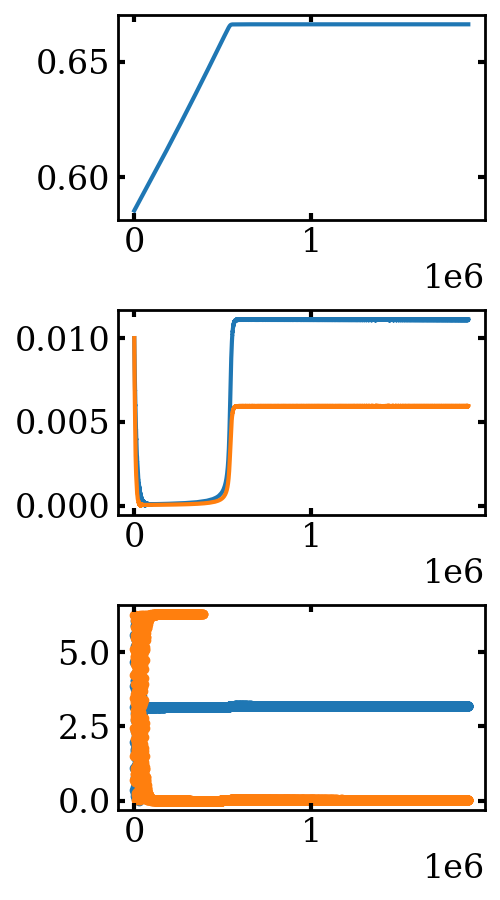

In [182]:
fig, ax = plt.subplots(3, figsize=(5, 9))
ax[0].plot(y[0, :], (y[5, :]/y[7, :])**(1.5))
#ax[0].plot(y[0, :], y[5, :])
#ax[0].plot(y[0, :], y[7, :])
ax[1].plot(y[0, :], y[1, :])
ax[1].plot(y[0, :], y[3, :])
ax[2].scatter(y[0, :], (-y[6,:]-y[4, :]) % (2 * np.pi))
ax[2].scatter(y[0, :], (-y[6,:]-y[2, :]) % (2 * np.pi))
fig.tight_layout()

# l1 and l2 integration dissipation. Ignore.

In [ ]:
Te1, Te2, Tm1, Tm2 = symbols(r"T_{\rm{e}1} T_{\rm{e}2} T_{\rm{m}1} T_{\rm{m}2}")

In [ ]:
a1dot_dis = -a1/Tm1 - 2*e1**2*a1/Te1
a2dot_dis = -a2/Tm2 - 2*e2**2*a2/Te2

e1dot_dis = -e1/Te1
e2dot_dis = -e2/Te2

a1dot_dis,e1dot_dis,a2dot_dis,e2dot_dis

In [ ]:
L1dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(L1).diff(a1)*a1dot_dis).simplify()
L1dot_dis

In [ ]:
L2dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(L2).diff(a2)*a2dot_dis).simplify()
L2dot_dis

In [ ]:
X1dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(X1_expr).diff(e1)*e1dot_dis + delaunay_to_orbelts(X1_expr).diff(a1)*a1dot_dis).subs(sin(g1),X1/sqrt(2*G1)).subs(G1,Rational(1,2)*(X1**2+Y1**2)).expand()
Y1dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(Y1_expr).diff(e1)*e1dot_dis + delaunay_to_orbelts(Y1_expr).diff(a1)*a1dot_dis).subs(cos(g1),Y1/sqrt(2*G1)).subs(G1,Rational(1,2)*(X1**2+Y1**2)).expand()

In [ ]:
X2dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(X2_expr).diff(e2)*e2dot_dis + delaunay_to_orbelts(X2_expr).diff(a2)*a2dot_dis).subs(sin(g2),X2/sqrt(2*G2)).subs(G2,Rational(1,2)*(X2**2+Y2**2)).expand()
Y2dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(Y2_expr).diff(e2)*e2dot_dis + delaunay_to_orbelts(Y2_expr).diff(a2)*a2dot_dis).subs(cos(g2),Y2/sqrt(2*G2)).subs(G2,Rational(1,2)*(X2**2+Y2**2)).expand()

In [ ]:
X1_dot = H3.diff(Y1) + X1dot_dis
Y1_dot = -H3.diff(X1) + Y1dot_dis
X2_dot = H3.diff(Y2) + X2dot_dis
Y2_dot = -H3.diff(X2) + Y2dot_dis

In [ ]:
l1_dot = H3.diff(L1)
l1_dot

In [ ]:
l2_dot = H3.diff(L2)
l2_dot

In [ ]:
L1_dot = -H3.diff(l1) + L1dot_dis
L2_dot = -H3.diff(l2) + L2dot_dis

In [ ]:
def plugin(expr):
    return expr.subs({
        mu2:1e-3,
        q:0.5,
        f1:f1val,
        f2:f2val,
        j:2,
        Tm1:np.inf,
        Tm2:1e6,
        Te1:2e3,
        Te2:1e3,
        om1:0,
        om2:0,
    })

In [ ]:
X1_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(X1_dot), modules="numpy")
Y1_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(Y1_dot), modules="numpy")
X2_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(X2_dot), modules="numpy")
Y2_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(Y2_dot), modules="numpy")
L1_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(L1_dot), modules="numpy")
l1_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(l1_dot), modules="numpy")
L2_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(L2_dot), modules="numpy")
l2_eom = lambdify([X1, Y1, X2, Y2, L1, l1, L2, l2], plugin(l2_dot), modules="numpy")

In [ ]:
plugin(l2_dot)

In [ ]:
def f(t, Y):
    return np.array(
        [
            X1_eom(*Y),
            Y1_eom(*Y),
            X2_eom(*Y),
            Y2_eom(*Y),
            L1_eom(*Y),
            l1_eom(*Y),
            L2_eom(*Y),
            l2_eom(*Y),
        ]
    )

In [ ]:
sol = sp.integrate.solve_ivp(f, (0,1),np.float64([0.1,0,0,0.1,np.sqrt(0.7),-3*np.pi/4,np.sqrt(1),0]),rtol=1e-6,atol=1e-6)

TypeError: loop of ufunc does not support argument 0 of type Symbol which has no callable sin method

# Migrating inward

In [ ]:
X1_dot = H4.diff(Y1) + X1dot_dis
Y1_dot = -H4.diff(X1) + Y1dot_dis
X2_dot = H4.diff(Y2) + X2dot_dis
Y2_dot = -H4.diff(X2) + Y2dot_dis

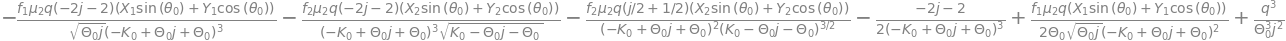

In [ ]:
th0_dot = H4.diff(Th0)
th0_dot

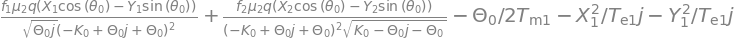

In [ ]:
Th0_dot = -H4.diff(th0) + Th0dot_dis
Th0_dot

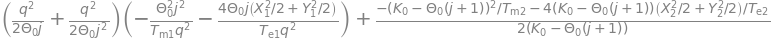

In [ ]:
K0_dot = K0dot_dis
K0_dot

In [ ]:
def plugin(expr):
    return expr.subs({
        mu2:1e-3,
        q:0.5,
        f1:f1val,
        f2:f2val,
        j:2,
        Tm1:np.inf,
        Tm2:1e6,
        Te1:2e3,
        Te2:1e3,
        om1:0,
        om2:0,
    })

In [ ]:
lambdify?

In [ ]:
X1_eom  = lambdify([X1,Y1,X2,Y2,Th0,th0,K0],plugin(X1_dot),modules="numpy")
Y1_eom  = lambdify([X1,Y1,X2,Y2,Th0,th0,K0],plugin(Y1_dot),modules="numpy")
X2_eom  = lambdify([X1,Y1,X2,Y2,Th0,th0,K0],plugin(X2_dot),modules="numpy")
Y2_eom  = lambdify([X1,Y1,X2,Y2,Th0,th0,K0],plugin(Y2_dot),modules="numpy")
Th0_eom = lambdify([X1,Y1,X2,Y2,Th0,th0,K0],plugin(Th0_dot),modules="numpy")
th0_eom = lambdify([X1,Y1,X2,Y2,Th0,th0,K0],plugin(th0_dot),modules="numpy")
K0_eom  = lambdify([X1,Y1,X2,Y2,Th0,th0,K0],plugin(K0_dot),modules="numpy")

In [ ]:
K0_eom

<function _lambdifygenerated(X_1, Y_1, X_2, Y_2, Theta_0, theta_0, K_0)>

In [ ]:
def f(t, Y):
    return np.array(
        [
            X1_eom(*Y),
            Y1_eom(*Y),
            X2_eom(*Y),
            Y2_eom(*Y),
            Th0_eom(*Y),
            th0_eom(*Y),
            K0_eom(*Y),
        ]
    )

In [ ]:
(2/3*0.99)**(2./3)

In [ ]:
Th0_init = delaunay_to_orbelts(genF1["Th0"]).subs({a1:0.7,j:2,q:0.5}).evalf()
print(Th0_init)
K0_init = delaunay_to_orbelts(genF1["K0"]).subs({a1:0.7,a2:1,j:2,q:0.5}).evalf()
print(K0_init)
sol = sp.integrate.solve_ivp(f, (0,200000),[0.1,0,0,0.1,Th0_init,-3*np.pi/4,K0_init],rtol=1e-6,atol=1e-6)

0.209165006633519
1.62749501990056


In [ ]:
sp.integrate.solve_ivp?

Signature:
sp.integrate.solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rew

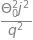

In [ ]:
a1_Th0 = solve(delaunay_to_orbelts(genF1["Th0"])-Th0,a1)[0]
a1_func = lambdify([Th0,j,q],a1_Th0)
a1_vals = a1_func(sol.y[4,:],2,0.5)
a1_vals = np.float64(a1_vals)
a1_Th0

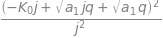

In [ ]:
a2_K0Th0 = solve(delaunay_to_orbelts(genF1["K0"])-K0,a2)[0]
a2_func = lambdify([K0,a1,j,q],a2_K0Th0)
a2_vals = a2_func(sol.y[6,:],a1_vals,2,0.5)
a2_K0Th0

In [ ]:
sol.y=np.float64(sol.y)

In [ ]:
pom1 = (-np.arctan2(sol.y[0,:],sol.y[1,:]))%(2*np.pi)
pom2 = (-np.arctan2(sol.y[2,:],sol.y[3,:]))%(2*np.pi)
th0 = sol.y[5,:] % (2*np.pi)

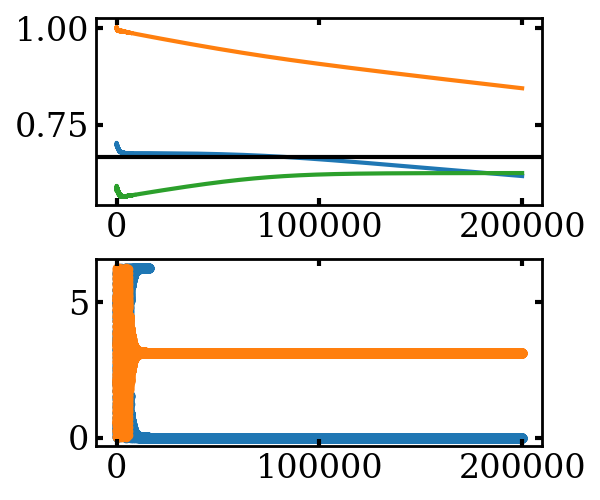

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(sol.t,a1_vals)
ax[0].plot(sol.t,a2_vals)
ax[0].plot(sol.t,(a1_vals/a2_vals)**(1.5))
ax[0].axhline(y=(2/3))
ax[1].scatter(sol.t, (-th0-pom1)%(2*np.pi))
ax[1].scatter(sol.t, (-th0-pom2)%(2*np.pi))
fig.tight_layout()

In [ ]:
sp.integrate.solve_ivp?

Signature:
sp.integrate.solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rew

Signature:
sp.integrate.solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rew